# Quantum ML Project - Binary Classification on the Parity problem  |  Task (c)

Install pennylane

In [6]:
# %pip install pennylane
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn

In [7]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Data
Data is generated using the parity function. The parity function is a function that returns 1 if the number of 1s in the input is odd, and 0 otherwise. The input is a binary string of length n. The parity function is a well-known example of a function that is not efficiently learnable by a classical neural network. However, it can be learned efficiently by a quantum neural network.

## Read

In [8]:
train_classA = np.loadtxt('./data/classA_train_N5.dat')
train_classB = np.loadtxt('./data/classB_train_N5.dat')
test_classA = np.loadtxt('./data/classA_test_N5.dat')
test_classB = np.loadtxt('./data/classB_test_N5.dat')

train_data = np.vstack((train_classA, train_classB))
train_labels = np.hstack((np.zeros(len(train_classA)), np.ones(len(train_classB))))

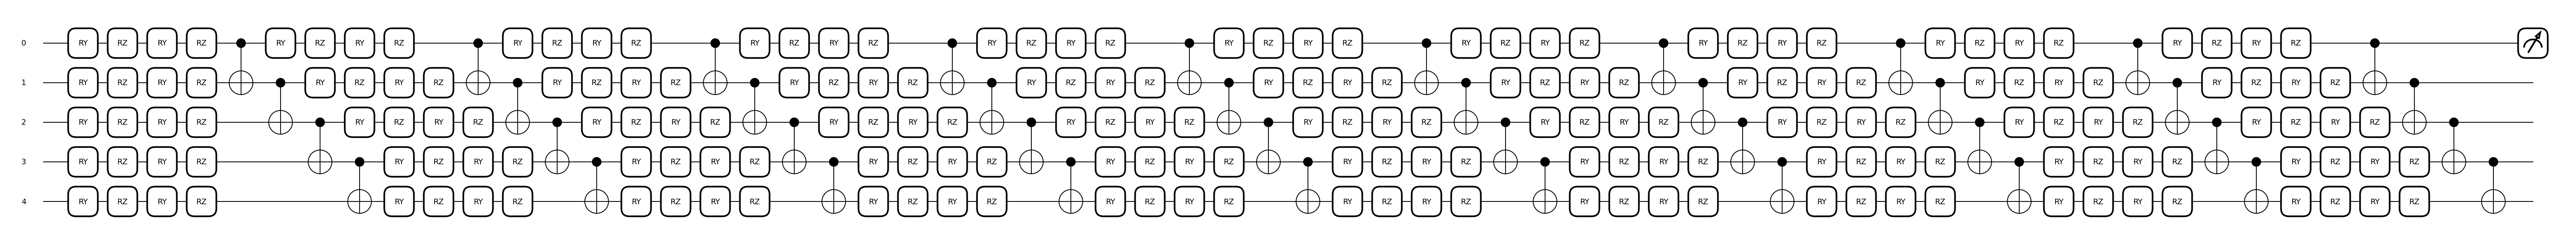

Iter: 1 | Train Cost: 0.4874 | Train Accuracy: 0.5312 | Test Accuracy: 0.5667
Iter: 2 | Train Cost: 0.4196 | Train Accuracy: 0.5188 | Test Accuracy: 0.5500
Iter: 3 | Train Cost: 0.3502 | Train Accuracy: 0.5188 | Test Accuracy: 0.5833
Iter: 4 | Train Cost: 0.2935 | Train Accuracy: 0.5813 | Test Accuracy: 0.6000
Iter: 5 | Train Cost: 0.2836 | Train Accuracy: 0.5375 | Test Accuracy: 0.5667
Iter: 6 | Train Cost: 0.2747 | Train Accuracy: 0.4813 | Test Accuracy: 0.6000
Iter: 7 | Train Cost: 0.2672 | Train Accuracy: 0.5250 | Test Accuracy: 0.6500
Iter: 8 | Train Cost: 0.2680 | Train Accuracy: 0.6000 | Test Accuracy: 0.6667
Iter: 9 | Train Cost: 0.2724 | Train Accuracy: 0.5875 | Test Accuracy: 0.5667
Iter: 10 | Train Cost: 0.2579 | Train Accuracy: 0.5563 | Test Accuracy: 0.5500
Iter: 11 | Train Cost: 0.2488 | Train Accuracy: 0.6062 | Test Accuracy: 0.5667
Iter: 12 | Train Cost: 0.2433 | Train Accuracy: 0.6062 | Test Accuracy: 0.5500
Iter: 13 | Train Cost: 0.2303 | Train Accuracy: 0.6750 | Test

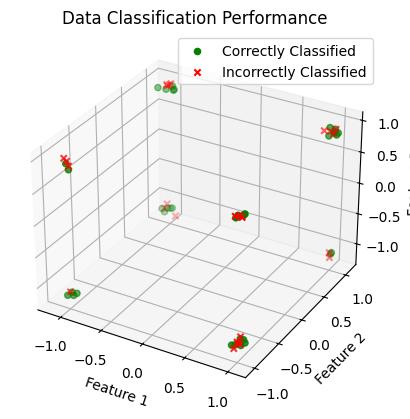

In [18]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Combine and label the datasets
X_train = np.vstack((train_classA, train_classB))
Y_train = np.hstack((np.zeros(len(train_classA)), np.ones(len(train_classB))))
X_test = np.vstack((test_classA, test_classB))
Y_test = np.hstack((np.zeros(len(test_classA)), np.ones(len(test_classB))))

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the quantum device
n_qubits = 5
n_layers = 2
dev = qml.device('default.qubit', wires=n_qubits)
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss /= len(labels)
    return loss
n_qubits = train_data.shape[1]
num_reuploads = 10
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(weights, x):
    for layer in range(num_reuploads):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
            qml.RZ(weights[layer, i, 0], wires=i)
            qml.RY(weights[layer, i, 1], wires=i)
            qml.RZ(weights[layer, i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))

qnode = qml.QNode(circuit, dev)

weights_init = 0.01 * np.random.randn(num_reuploads, n_qubits, 3)
fig, ax = qml.draw_mpl(circuit)(weights_init, np.zeros(n_qubits))
plt.show()

def variational_classifier(weights, bias, x):
    return qnode(weights, x) + bias

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

def train(X, Y, num_reuploads, optimizer, learning_rate=0.1, epochs=50, batch_size=5, patience=5):
    np.random.seed(0)
    weights_init = 0.01 * np.random.randn(num_reuploads, n_qubits, 3)
    bias_init = np.array(0.0, requires_grad=True)

    opt = optimizer(learning_rate)
    weights = weights_init
    bias = bias_init

    train_costs = []
    test_accuracies = []
    train_accuracies = []

    best_loss = np.inf
    patience_counter = 0
    for it in range(epochs):
        batch_index = np.random.randint(0, len(X), (batch_size,))
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)
        
        train_predictions = [variational_classifier(weights, bias, x) for x in X]
        train_acc = np.mean((np.array(train_predictions) > 0.5) == Y)
        
        test_predictions = [variational_classifier(weights, bias, x) for x in X_test]
        test_acc = np.mean((np.array(test_predictions) > 0.5) == Y_test)
        
        train_cost = cost(weights, bias, X, Y)
        train_costs.append(train_cost)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        print(f"Iter: {it+1} | Train Cost: {train_cost:.4f} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
    
        # Early stopping
        if train_cost < best_loss:
            best_loss = train_cost
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return weights, bias, train_costs, train_accuracies, test_accuracies
def evaluate(weights, bias, X, Y):
    predictions = np.array([variational_classifier(weights, bias, x) for x in X])
    accuracy = np.mean((predictions > 0.5) == Y)
    print(f"Accuracy: {accuracy:.4f}")
    return predictions, accuracy

def visualize_performance(X, Y, predictions):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    correctly_classified = (predictions > 0.5) == Y
    incorrectly_classified = ~correctly_classified

    ax.scatter(X[correctly_classified, 0], X[correctly_classified, 1], X[correctly_classified, 2], c='green', marker='o', label='Correctly Classified')
    ax.scatter(X[incorrectly_classified, 0], X[incorrectly_classified, 1], X[incorrectly_classified, 2], c='red', marker='x', label='Incorrectly Classified')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title("Data Classification Performance")
    ax.legend()
    plt.show()
# Train the model
epochs = 50
weights, bias, train_costs, train_accuracies, test_accuracies = train(train_data, train_labels, num_reuploads, AdamOptimizer, learning_rate=0.1, epochs=epochs, batch_size=5)

# Evaluate the model on test data
predictions, accuracy = evaluate(weights, bias, X_test, Y_test)

# Visualize the performance
visualize_performance(X_test, Y_test, predictions)
# plot_metrics(range(0, epochs), train_costs, train_accuracies, test_accuracies)

# NN

In [15]:
%pip install torch

  Using cached torch-2.3.0-cp39-cp39-win_amd64.whl.metadata (26 kB)
  Using cached filelock-3.14.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
  Using cached MarkupSafe-2.1.5-cp39-cp39-win_amd64.whl.metadata (3.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.3.0-cp39-cp39-win_amd64.whl (159.7 MB)
Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)
Using cached tbb-2021.12.0-py3-none-win_amd64.whl (286 kB)
Using cached filelock-3.14.0-py3-none-any.whl (12 kB)
   ---------------------------------------- 0.0/316.1 kB ? eta -:--:--
  

In [17]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the quantum device
n_qubits = X_train.shape[1]
num_reuploads = 5
dev = qml.device("default.qubit", wires=n_qubits)

# Define the variational quantum circuit with entangling layers
def circuit(weights, x):
    for layer in range(num_reuploads):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
            qml.RZ(weights[layer, i, 0], wires=i)
            qml.RY(weights[layer, i, 1], wires=i)
            qml.RZ(weights[layer, i, 2], wires=i)
        qml.broadcast(unitary=qml.CNOT, pattern="chain", wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

qnode = qml.QNode(circuit, dev)

# Initialize weights
weights_init = 0.01 * np.random.randn(num_reuploads, n_qubits, 3)

# Define the classifier with a classical neural network
class HybridModel(nn.Module):
    def __init__(self, quantum_weights, n_qubits):
        super(HybridModel, self).__init__()
        self.quantum_weights = quantum_weights
        self.fc1 = nn.Linear(n_qubits, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        q_out = torch.tensor([qnode(self.quantum_weights, x_i.detach().numpy()) for x_i in x], dtype=torch.float32)
        x = torch.relu(self.fc1(q_out))
        x = torch.sigmoid(self.fc2(x))
        return x

# Convert data to torch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

# Training the hybrid model
quantum_weights = nn.Parameter(torch.tensor(weights_init, dtype=torch.float32))
model = HybridModel(quantum_weights, n_qubits)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.5)

def train_model(model, criterion, optimizer, X_train, Y_train, X_test, Y_test, epochs=50):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_predictions = (test_outputs > 0.5).float()
            test_accuracy = (test_predictions == Y_test).float().mean().item()
            test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, test_accuracies

# Train the model
train_losses, test_accuracies = train_model(model, criterion, optimizer, X_train_torch, Y_train_torch, X_test_torch, Y_test_torch, epochs=50)

# Plot training loss and test accuracy
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.title('Hybrid Model Training Metrics')
plt.legend()
plt.show()


Epoch 1/50, Loss: 0.6996, Test Accuracy: 0.5000
Epoch 2/50, Loss: 1.0234, Test Accuracy: 0.5000
Epoch 3/50, Loss: 0.6976, Test Accuracy: 0.5000
Epoch 4/50, Loss: 0.7029, Test Accuracy: 0.5000
Epoch 5/50, Loss: 0.7178, Test Accuracy: 0.5000
Epoch 6/50, Loss: 0.7188, Test Accuracy: 0.5000
Epoch 7/50, Loss: 0.7104, Test Accuracy: 0.5000
Epoch 8/50, Loss: 0.7000, Test Accuracy: 0.5000
Epoch 9/50, Loss: 0.6933, Test Accuracy: 0.5000
Epoch 10/50, Loss: 0.6927, Test Accuracy: 0.5000
Epoch 11/50, Loss: 0.6963, Test Accuracy: 0.5000
Epoch 12/50, Loss: 0.7005, Test Accuracy: 0.5167
Epoch 13/50, Loss: 0.7023, Test Accuracy: 0.5167
Epoch 14/50, Loss: 0.7008, Test Accuracy: 0.5167
Epoch 15/50, Loss: 0.6972, Test Accuracy: 0.5167
Epoch 16/50, Loss: 0.6940, Test Accuracy: 0.5000
Epoch 17/50, Loss: 0.6924, Test Accuracy: 0.5000
Epoch 18/50, Loss: 0.6929, Test Accuracy: 0.5000
Epoch 19/50, Loss: 0.6944, Test Accuracy: 0.5000
Epoch 20/50, Loss: 0.6952, Test Accuracy: 0.5000
Epoch 21/50, Loss: 0.6955, Te

KeyboardInterrupt: 